In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Lecture 7 - Classification, Generalization, Overfitting, Evaluation, Cross-validation and Scikit-learn

---

### Content

1. Classification
2. Generalization
3. Overfitting
4. Classifiers goodness-of-fit
5. Cross-validation
6. Comparing multiple classifiers
7. Scikit-learn
8. Feature Selection


### Learning Outcomes

At the end of this lecture, you should be able to:

* explain the difference between classification and regression
* explain the theory of generalization, the phenomenon of overfitting, and the 'no free lunch' theorem
* discuss and apply various measures for evaluating classifier accuracy
* use cross-validation for training and evaluating classifiers
* compare the accuracies of multiple classification algorithms across multiple datasets
* explain the rationale of feature selection and apply it 
---

# Classification

# Parametric and non-parametric classification algorithms in machine learning

Machine learning algorithms can be broadly categorised into parametric and non-parametric algorithms.  

>    A learning model that summarizes data with a set of parameters of fixed size (independent of the number of training examples) is called a parametric model. No matter how much data you throw at a parametric model, it won’t change its mind about how many parameters it needs. — Artificial Intelligence: A Modern Approach

**Parametric algorithms** make strong assumptions about the data and are fixed in their complexity/size. Algorithms of this type are:  Logistic Regression,  Perceptron, Neural Networks and the algorithm we will look at today, Naive Bayes.

There are some advantages and disadvantages associated with these types of algorithms. They tend to be simpler due to few parameters and can be more interpretable. They are also faster to train on average and may require smaller datasets. Their weakness is their inflexibility and the highly constrained form, which, if unsuitable for the particular problem, will generate a poor fit. Often, these kinds of algorithms are more suited to less complex domains.


**Non-parametric machine learning algorithms** do not make strong assumptions about the form of the mapping function that maps features to class labels. Because of this, they have more flexibility in learning the decision boundaries. These kinds of algorithms are good, when you do not have much prior knowledge about the data and have access to reasonably large datasets.

>Nonparametric methods are good when you have a lot of data and no prior knowledge, and when you don’t want to worry too much about choosing just the right features. — Artificial Intelligence: A Modern Approach

Some examples of non-parametric machine learning algorithms are: k-Nearest Neighbors, Boosting, Decision Trees, Random Forest, SVM. 

Benefits of these algorithms come in their flexibility and the absence of strong assumptions needed to do training. Also, they tend to have stronger performances. The down side to them is that they do require more data and runtime to train. Their biggest disadvantage would be their propensity to overfit.


### Example dataset - Wine

We will return to the Wine dataset to explore classification.

In [93]:
import pandas as pd
import numpy as np
import matplotlib as mtpl
import seaborn as sns


%matplotlib inline

df = pd.io.parsers.read_csv(
    '../datasets/wine_data.csv',
     usecols=[0,6,7]
    )

df.columns=['Class','Magnesium','Flavanoids']

df['Class'].replace('3', 0, inplace=True)
df.to_csv('../datasets/wine_data_test.csv', header=None, index=None)

df.head(5)

,Class,Magnesium,Flavanoids
0,1,2.80,3.06
1,1,2.65,2.76
2,1,2.80,3.24
3,1,3.85,3.49
4,1,2.80,2.69


Confirm we have 3 class labels:

In [94]:
df.Class.unique()


array([1, 2, 3])

Confirm data types:

In [95]:
df.dtypes


Class           int64
Magnesium     float64
Flavanoids    float64
dtype: object

Get counts for each class:

In [9]:
df.groupby('Class').count()

,Magnesium,Flavanoids
Class,,
1,59,59
2,71,71
3,48,48


In [96]:
df.groupby('Class').count() / df.groupby('Class').count()['Magnesium'].sum()

,Magnesium,Flavanoids
Class,,
1,0.331461,0.331461
2,0.398876,0.398876
3,0.269663,0.269663


In classification problems, the **ability to separate classes** from one another is the most important consideration. Histograms of the feature values per class type, can be a useful tool for **eyeballing** some features and to get a rough feeling for their **discriminative power**. 

Here we are visualising the histograms of the two features for each of the three classes:

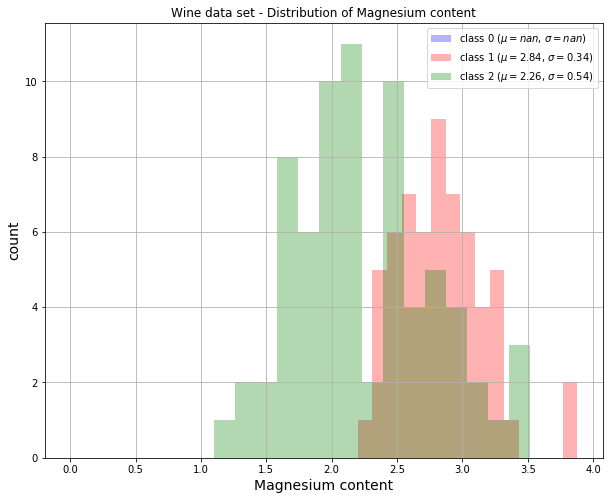

In [11]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))

colors = ('blue', 'red', 'green')

for label,color in zip(range(0,3), colors):
    mean = np.mean(df['Magnesium'][df['Class'] == label]) # class sample mean
    stdev = np.std(df['Magnesium'][df['Class'] == label]) # class standard deviation
    df['Magnesium'][df['Class'] == label].hist(alpha=0.3, # opacity level
             label='class {} ($\mu={:.2f}$, $\sigma={:.2f}$)'.format(label, mean, stdev), 
             color=color,
             bins=15)

plt.title('Wine data set - Distribution of Magnesium content')
plt.xlabel('Magnesium content', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.legend(loc='upper right')

plt.show()

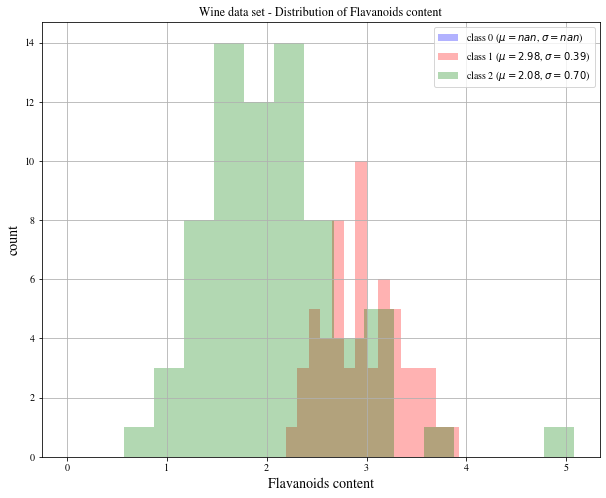

In [97]:

plt.figure(figsize=(10,8))

colors = ('blue', 'red', 'green')

for label,color in zip(range(0,3), colors):
    mean = np.mean(df['Flavanoids'][df['Class'] == label]) # class sample mean
    stdev = np.std(df['Flavanoids'][df['Class'] == label]) # class standard deviation
    df['Flavanoids'][df['Class'] == label].hist(alpha=0.3, # opacity level
             label='class {} ($\mu={:.2f}$, $\sigma={:.2f}$)'.format(label, mean, stdev), 
             color=color,
             bins=15)

plt.title('Wine data set - Distribution of Flavanoids content')
plt.xlabel('Flavanoids content', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.legend(loc='upper right')

plt.show()

Let's see classification on this dataset in action.

We will use the knn classifier.

In [98]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing

We will first normalise all the features using standardisation with the built in method provided by scikit-learn: 

In [105]:
std_scale = preprocessing.StandardScaler().fit(df[['Flavanoids', 'Magnesium']].dropna())
X = std_scale.transform(df[['Flavanoids', 'Magnesium']].dropna())
X.shape
X

array([[ 1.03481896e+00,  8.08997395e-01],
       [ 7.33628941e-01,  5.68647662e-01],
       [ 1.21553297e+00,  8.08997395e-01],
       [ 1.46652465e+00,  2.49144552e+00],
       [ 6.63351271e-01,  8.08997395e-01],
       [ 1.36612798e+00,  1.56209322e+00],
       [ 4.92676928e-01,  3.28297930e-01],
       [ 4.82637261e-01,  4.88531085e-01],
       [ 9.54501620e-01,  8.08997395e-01],
       [ 1.12517596e+00,  1.09741707e+00],
       [ 1.29585031e+00,  1.04934713e+00],
       [ 4.02319923e-01, -1.52401534e-01],
       [ 7.33628941e-01,  4.88531085e-01],
       [ 1.66731799e+00,  1.28969686e+00],
       [ 1.61711966e+00,  1.61016317e+00],
       [ 8.84223950e-01,  8.89113972e-01],
       [ 1.11513630e+00,  8.08997395e-01],
       [ 1.37616764e+00,  1.04934713e+00],
       [ 1.90827001e+00,  1.61016317e+00],
       [ 1.00469996e+00,  6.48764240e-01],
       [ 1.14525530e+00,  1.12946370e+00],
       [ 3.82240589e-01,  1.84088091e-01],
       [ 8.54104948e-01,  5.04554400e-01],
       [ 3.

The above gives us our X values that are our features.

Next we extract the corresponding class values for each value of x:

In [106]:
y = df.Class
y.shape

(178,)

We can now train our classifier on our training dataset:

In [107]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Having trained our classifier, we now need to see how well it has trained. 

For this we use the same dataset that we trained the classifier on. This dataset is called the training dataset. 

We ask the classifier to predict the class label for each of the x values in our training dataset.

In [109]:
classification_results = knn_classifier.predict(X)
classification_results

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 2, 1, 2, 1,
       1, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 3, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3])

The above shows all the classifications/prediction that the classifier makes for each value x.

We can put this into the original dataframe for later analysis:

In [110]:
df['Classification'] = classification_results
df.head()

,Class,Magnesium,Flavanoids,Classification
0,1,2.80,3.06,1
1,1,2.65,2.76,1
2,1,2.80,3.24,1
3,1,3.85,3.49,1
4,1,2.80,2.69,1


We can calculate the overall accuracy of our training error on the training dataset which is one way of summarising the effectiveness of our training and is an important step in evaluating classifier training before moving forward to next steps.

In [112]:
knn_classifier.score(X, y)

0.8089887640449438

Valid questions now are:

1. What does the classification accuracy of a classifier on a training dataset tell us about how accurate it will be on data which is outside of the training dataset?

2. How can we be confident that our classifier will perform to similar levels of accuracy on data it has not been trained on?

3. Will the classifier generalize beyond the training dataset?

# Generalization

The goal of training a classifier, or creating a predictive model on a particular dataset is not so that it would make accurate predictions only on these samples. To use an absurd scenario, we could potentially create a look-up table, or an immense set of if-else statements for every example in a dataset and thereby achieve 100% accuracy. This process would be called memorising the data and is practically useless for the task of predictive analytics.

Instead, the **goal is that the classifier would uncover and encode patterns describing the underlying structural relationships, with the intention of them generalising and thus being able to accurately predict data that the algorithm has not previously "seen"**. This is referred to as  generalization. In essence, machine learning is the attempt to take the limited amount of information it can gather and generalise. It embodies the movement from the 'specific to the general'.

Generalization is the property of a classifier or modelling process, whereby the classifier is relevant for prediction purposes on data that were not used to train it. We must keep in mind that every dataset is a finite sample of a total population for a given domain (unless you have a dataset that contains all samples that will ever be used to describe a given problem.). And we want the classifier to be fit-for-purpose on the population of a given domain as a whole.

Hence, **creating a classifier that is perfectly accurate on one training dataset is no guarantee of it being accurate at predicting unseen samples**. In fact, machine learning algorithms are notoriously susceptible to finding meaningless, or phantom patterns that are random idiosyncrasies within a given dataset sample, and have no value beyond the data outside of the training dataset. 

Sometimes we may have concerns that the training data were not representative of the true population which leads to bad generalization - and this does happen, often. The data can be noisy (mislabelled or erroneous data), have lots of outliers (valid but extreme values). But often it is the case that the algorithm used to train a classifier or build a model, created too good of a "fit" (too complex) on the training dataset that is ultimately useless and misleading beyond the samples it trained on.

Training classifiers which are variable-size (optimisable) and can thus increase in complexity, often leads to the pattern below. Both the training and generalisation (test) error decrease initially during the early stages of classifier training. If the training ceases too early, then the classifier has usually not been given enough time to learn the separating class decision boundary sufficiently. This is referred to as underfitting. As the training algorithm builds a more complex classifier (model), the training error will continue to decrease. As the training error approaches zero, the training algorithm is said to 'converge'. However, complete convergence does not necessarily mean that the classifier will generalise well. It is usually quite easy to achieve full convergence on a training set. The difference between the final training error (convergence) and the generalisation (test) error is the indicator of the degree of overfitting that has occurred. 

Generalisation error will always be greater than the training error. However, we want this difference to be as small as possible.   

![Source Wikipedia](../figures/generalization_overfitting.jpg)

Source: Janert, P. K. (2010). Data analysis with open source tools.  O'Reilly Media, Inc

# Overfitting

**Overfitting is usually what happens when classifier generalization is not achieved**. It is the tendency of machine learning and data mining algorithms to tailor classifiers to the training data, at the expense of generalization to previously unseen data points. 

It should be noted that inherent within all machine learning and data mining algorithms is the tendency to overfit to some degree. Some algorithms will accentuate this tendency more than others and it will often depend on the dataset and the type of the problem.

If we try hard enough and push the classifiers to become more and more complex, the algorithms will invariably find patterns in a dataset. The Nobel Laureate Ronald Coase one said

> “If you torture the data long enough, it will confess.”

The problem of overfitting is probably one of the greatest challenges for a data scientist.

> The answer is not to use a data mining procedure
that doesn’t overfit because all of them do. Nor is the answer to simply use models
that produce less overfitting, because there is a fundamental trade-off between model
complexity and the possibility of overfitting. Sometimes we may simply want more
complex models, because they will better capture the real complexities of the application
and thereby be more accurate. There is no single choice or procedure that will eliminate
overfitting. The best strategy is to recognize overfitting and to manage complexity in a
principled way.

Provost, F., & Fawcett, T. (2013). Data Science for Business: What you need to know about data mining and data-analytic thinking. " O'Reilly Media, Inc.".

In [113]:
from time import sleep
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams

rcParams['figure.figsize'] = 18, 10
rcParams['font.size'] = 20
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

wine_df = pd.read_csv(
    '../datasets/wine_data.csv'
    )

X = wine_df.iloc[:, 1:]
y = wine_df.iloc[:, :1]

treeclf = DecisionTreeClassifier(max_depth=1, random_state=1)


0.2584269662921348
0.0561797752808989
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


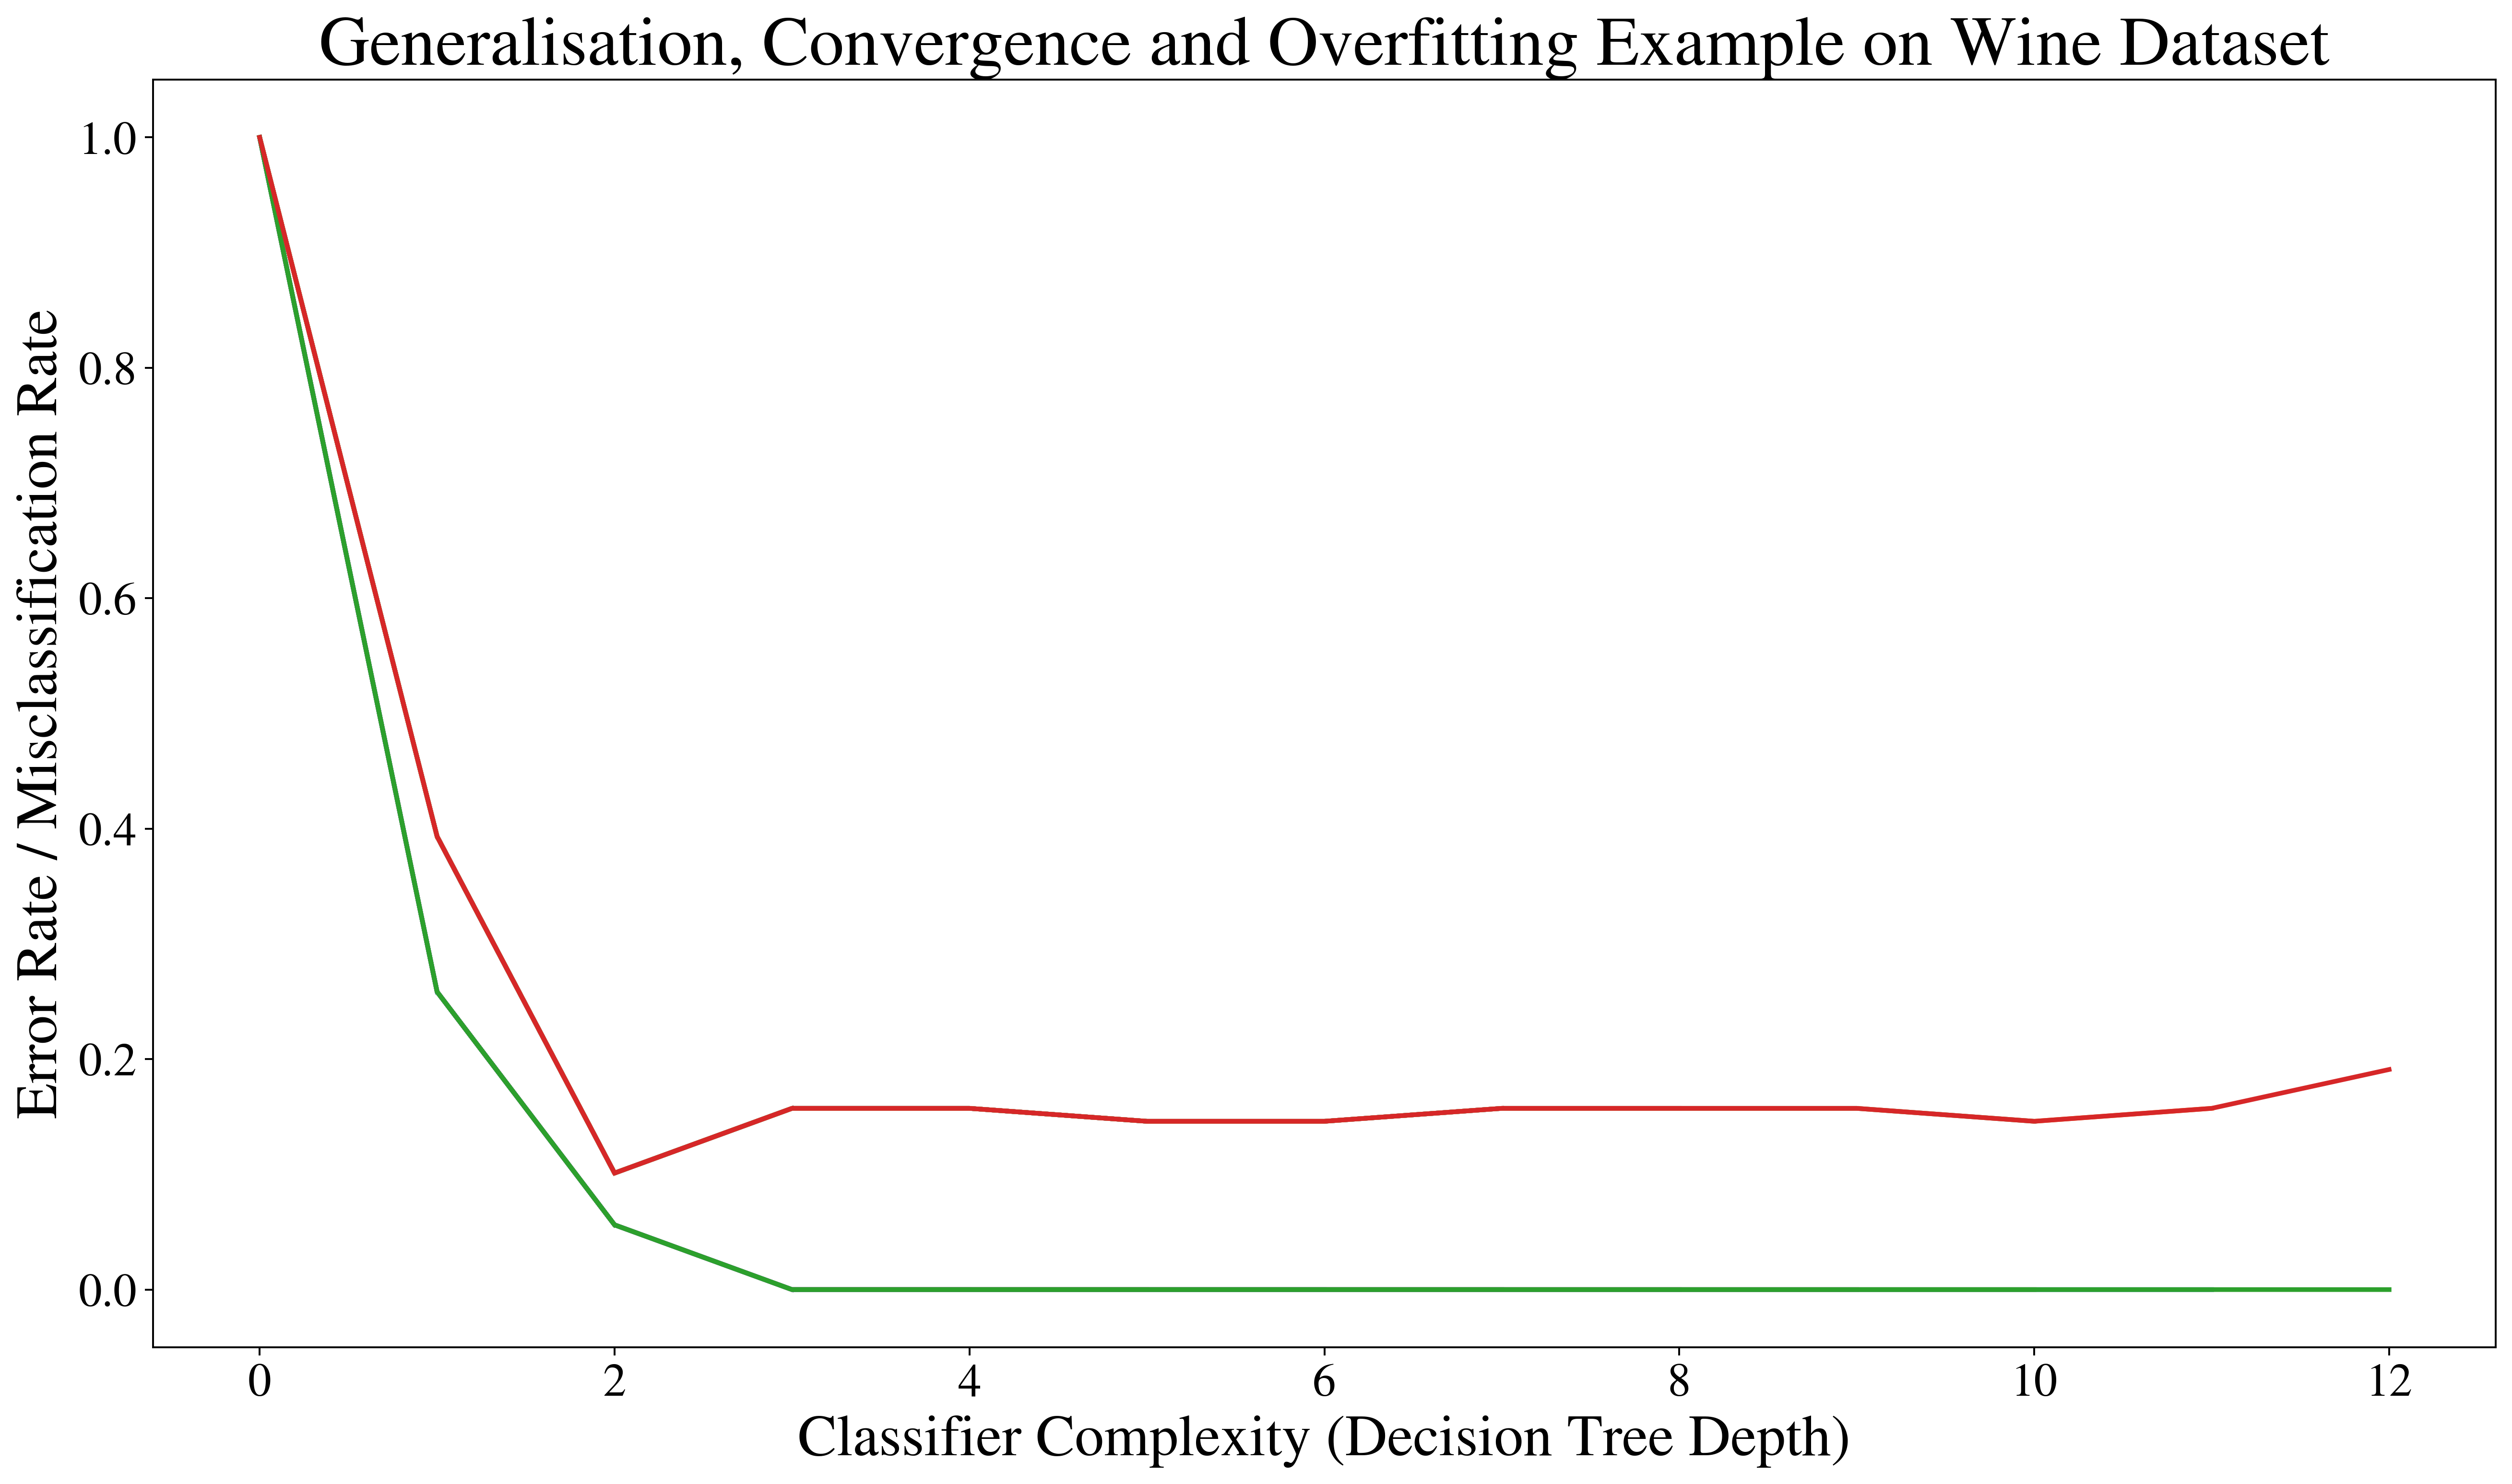

In [115]:
training_error = pd.Series([1.0])
test_error = pd.Series([1.0])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.5)
for i in range(1,13):
    treeclf = DecisionTreeClassifier(max_depth=i, random_state=i)
    training_error[i] = 1.0 - treeclf.fit(X_train, y_train).score(X_train, y_train) 
    test_error[i] = 1.0 - treeclf.fit(X_train, y_train).score(X_test, y_test) 
    plt.plot(training_error)
    plt.plot(test_error)
    plt.title('Generalisation, Convergence and Overfitting Example on Wine Dataset', size=30)
    plt.xlabel('Classifier Complexity (Decision Tree Depth)', size=25)
    plt.ylabel('Error Rate / Misclassification Rate', size=25)
#     print(training_error[i])

# Classifier Evaluation

In order to be able to ascertain if our classifier is both learning the training dataset (converging) or overfitting on previously unseen data, we need to have some evaluation metrics at our disposal. 

Fortunately the field of machine learning and data mining has been around for a long time so there are some very well established metric that enables us to evaluate our classifiers.

Multiclass classification problems are treated similarly, however, there is usually a greater need in multiclass problems to break down the classification results at per-class label level in order to examine the performance. This is often necessary in the presence of unbalanced class distributions. 

A binary class **confusion-matrix** is a good starting point to visualize and understand the performance of a classifier. Each column of the matrix represents the instances in a predicted class, while each row represents the instances in an actual class. The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabelling one as another).


![Source Wikipedia](../figures/confusion_matrix.jpg)

Source: http://en.wikipedia.org/wiki/Confusion_matrix



![Source Wikipedia](../figures/classification_terms.jpg)

Source: http://en.wikipedia.org/wiki/Confusion_matrix

## Accuracy

Is the most commonly used metric. It is simplistic but useful as the first step. It is the number of correctly classified samples divided by all the samples in the dataset.

**Exercise:** Given the Wine dataframe from above, write a function that accepts it and returns the overall accuracy for the dataset:

In [117]:
df

,Class,Magnesium,Flavanoids,Classification
0,1,2.80,3.06,1
1,1,2.65,2.76,1
2,1,2.80,3.24,1
3,1,3.85,3.49,1
4,1,2.80,2.69,1
...,...,...,...,...
173,3,1.68,0.61,3
174,3,1.80,0.75,3
175,3,1.59,0.69,3
176,3,1.65,0.68,3


In [118]:
def calculate_accuracy(df):
    #your code here
    correct = len(df[df.Class==df.Classification])
    total_sample = len(df)
    
    return correct/float(total_sample)

In [119]:
calculate_accuracy(df)

0.8089887640449438

The opposite of accuracy is the *error rate* and is reported quite often in literature. It is simply 1 - accuracy

## Recall

Evaluates how many samples that belong to a particular class as actually classified as belonging to that class.

**Exercise:** Given the Wine dataframe from above, write a function that accepts it and returns the recall (aka hit rate) for each class:

In [131]:
def calculate_recall_per_class(df):
    recall = {}
    #your code here
    for c in df.Class.unique():
        p = len(df[df.Class == c])
        tp = len(df[(df.Class==c) & (df.Classification==c)])
        recall[c] = tp/float(p)
        
    return recall

In [155]:
calculate_recall_per_class(df)
#should return something like:
#{1: 0.9322033898305084, 2: 0.6619718309859155, 3: 0.875}

{1: 0.9322033898305084, 2: 0.6619718309859155, 3: 0.875}

## False Positive Rate

False positive looks at the proportion of samples that are being incorrectly classified as belonging to a particular class, out of all samples that do not belong to that class.

**Exercise:** Given the Wine dataframe from above, write a function that accepts it and returns the false positive rate for each class:

In [135]:
def calculate_false_positive_rate_per_class(df):
    fp_rate = {}
    #your code here
    for c in df.Class.unique():
        fp = len(df[(df.Class != c) & (df.Classification==c) ])
        tn = len(df[ df.Class != c ])
        fp_rate[c] = fp / float(tn)
        
    return fp_rate

In [136]:
calculate_false_positive_rate_per_class(df)
#should return something like:
#{1: 0.13445378151260504, 2: 0.09345794392523364, 3: 0.06153846153846154}

{1: 0.13445378151260504, 2: 0.09345794392523364, 3: 0.06153846153846154}

## Precision

Precision takes into account the false positive classifications together with the true positive classifications.

**Exercise:** Given the Wine dataframe from above, write a function that accepts it and returns the precision rate for each class:

In [140]:
def calculate_precision_per_class(df):
    precision = {}
    #your code here
    for c in df.Class.unique():

        tp = len(df[(df.Class==c) & (df.Classification==c)])
        fp = len(df[(df.Class!=c) & (df.Classification==c)])
        precision[c] = tp/float(tp+fp)
        
    return precision

In [141]:
calculate_precision_per_class(df)
#should return something like:
#{1: 0.7746478873239436, 2: 0.8245614035087719, 3: 0.84}

{1: 0.7746478873239436, 2: 0.8245614035087719, 3: 0.84}

## F1-score

Another important measure that is insightful in respect to the accuracy of each given class label is the F-value (known also as the F-measure or the F1-score).

F1-score is particularly important for datasets with uneven class distributions. Training classifier on such problem is very difficult and all algorithms struggle to produce classifiers that accurately generalise on all class labels within such datasets. Usually the classes with the smallest number of samples experience the worst generalisation. The F1-score to some degree provides a more balanced assessment of a classifier's generalisation for each class label as it is the harmonic mean of the recall and precision values. The harmonic mean is a useful ttype of an average to use in this instance, since, unlike the arithmetic mean, the harmonic mean gives less significance to high-value outliers–providing a truer picture of the average.


**Exercise:** Given the Wine dataframe from above, write a function that accepts it and returns the f1-score for each class:

In [150]:
def calculate_f1score_per_class(df):
    f1score = {}
    #your code here
    for c in df.Class.unique():
        tp = len(df[(df.Class==c) & (df.Classification==c)])
        fp = len(df[(df.Class!=c) & (df.Classification==c)])
        fn = len(df[df.Class==c]) -tp
        f1score[c] = 2*tp/float(2*tp+fp+fn)             

        
    return f1score

In [151]:
calculate_f1score_per_class(df)
#should return something like:
#{1: 0.8461538461538461, 2: 0.734375, 3: 0.8571428571428571}

{1: 0.8461538461538461, 2: 0.734375, 3: 0.8571428571428571}

## Confusion Matrix

In a **multiclass scenario**, the binary confusion matrix seen above can easily be extended it an $n \times n$ matrix where $n$ is the number of classes. 

In a multiclass setting it is particularly informative to know which classes are being misclassified as labels of another class. 


**Exercise:** Given the Wine df_result from above, write a function that accepts it and returns a confusion matrix data frame:

In [32]:
def calculate_confusion_matrix(df):
    #your code here
            
    return 
    
    

In [33]:
calculate_confusion_matrix(df)


## Geometric Mean

Often though, on class-unbalanced problems, it is necessary to derive a single value to express the accuracy of a dataset. In these cases the total error (or accuracy) metrics as completely inadequate and a very good alternative is the Geometric mean of the recall values is defined as follows:


<div style="font-size: 120%;">  
$Geometric\ mean = \left(\prod_{i=1}^n Recall_i \right)^{1/n}$
</div>

The geometric mean gives a more conservative mean then the arithmetic mean and is thus more appropriate, hence its usage. 

**Exercise:** Write a function that calculates the geometric mean for the data frame below:

In [34]:
df.head()

,Class,Magnesium,Flavanoids,Classification
0,1,2.80,3.06,1
1,1,2.65,2.76,1
2,1,2.80,3.24,1
3,1,3.85,3.49,1
4,1,2.80,2.69,1


In [152]:
def calculate_geometric_mean(df):
    gmean = 1.0
    recall = calculate_recall_per_class(df)

    #YOUR CODE HERE 
    for  c in recall.values():
        gmean *= c
        

   
    return np.power(gmean, 1.0 / float(len(recall)))
    

In [156]:
calculate_geometric_mean(df)
#SHOULD PRODUCE 0.8143030848180245


0.8143030848180245

# Cross-Validation

Under generalization and overfitting, we discussed the importance of developing classifiers that do not just remember the training data but are able to generalize on data that the machine learning algorithms had not previously seen. One solution is to split datasets into training and test sets. The training is performed on one, and the generalization is determined on the other.

There are some problems with doing it this way. By defining  two sets, we reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, test) sets. Also, what proportion of data do we use for training and what for testing?

Another approach which is more robust, is to split the whole data several consecutive times in different
train set and test set combinations, and to return the averaged value of the prediction
scores obtained with the different sets. This technique is called **k-fold cross-validation**. Where the k determines the number segments that the data is to be split into. In this procedure, 1 fold is retained for testing the classifier and the other k-1 folds are used for training.

In the image example below, k=4 (4 folds). The classifier will be trained on the combination of 3 folds and  evaluated on the 4th fold (the test fold). This procedure is then repeated 4 times until every fold has been used as the test set once so that we can eventually calculate the average error rate of our model from the error rate of every iteration, which gives us an idea of how well our model generalizes.


![Source Wikipedia](../figures/cross-validation-001_small.png)

Source: https://github.com/rasbt/pattern_classification/blob/master/machine_learning/supervised_intro/images/cross-validation-001_small.png

Keep in mind that the algorithm at all times is provided with the correct answers, but when the algorithm makes predictions, it does not refer to them, but instead uses the correct answers only to compare its own prediction to.

Give the serious problem of class-imbalanced datasets, the most robust way to implement the above procedure is by using what is called the **stratified k-fold cross-validation**. By stratified, we mean that every fold will not only be of equal size as the other folds in terms of the number of samples, but every fold will also have an identical distribution of all class labels.

Overall, the cross-validation approach can be computationally expensive but it is worth the extra effort and it does not waste too much data
when creating the classifiers as it occurs  when fixing an arbitrary test set. This is an advantage in problems where the number of samples is very small. The question once you have trained and tested all your k classifiers is, which classifier to deploy in your application?




**Exercise:** Write a function that takes a dataframe, number of folds, column index that contains class labels, the number of features, number of classes, as well as the file name. The function will then create k stratified folds for cross-validation and write each individual fold to file with an appropriate name. Output for each class and each fold how many samples are being written so that you can confirm that your function is working.

In [157]:
def cross_fold_file_generator(df, kfolds, class_index, num_of_features, num_of_classes, file_stem):
    file_name = ['fold_' + str(x) for x in range(kfolds)]
    
     #your code here
        

For our wine dataset, the function should produce something like the following:

In [158]:
cross_fold_file_generator(df, kfolds = 5, class_index = 0, num_of_features = len(df.columns) - 1, num_of_classes = len(df['Class'].unique()), file_stem = '../datasets/wine_xfold_')

#should generate something like:
#class:  1 fold:  0 samples:  12
#class:  1 fold:  1 samples:  12
#class:  1 fold:  2 samples:  12
#class:  1 fold:  3 samples:  12
#class:  1 fold:  4 samples:  11
#class:  2 fold:  0 samples:  14
#class:  2 fold:  1 samples:  14
#class:  2 fold:  2 samples:  14
#class:  2 fold:  3 samples:  15
#class:  2 fold:  4 samples:  14
#class:  0 fold:  0 samples:  10
#class:  0 fold:  1 samples:  10
#class:  0 fold:  2 samples:  9
#class:  0 fold:  3 samples:  10
#class:  0 fold:  4 samples:  9

## Using sci-kit learn's evaluation metrics and dataset splitting functions

All that we have covered above is conveniently implemented for us in sci-kit learn.

In [159]:
df.head()

,Class,Magnesium,Flavanoids,Classification
0,1,2.80,3.06,1
1,1,2.65,2.76,1
2,1,2.80,3.24,1
3,1,3.85,3.49,1
4,1,2.80,2.69,1


We can train a kNN classifier again on all our training data as follows and use the model for prediction:

In [160]:
knn_classifier = knn_classifier.fit(df[['Magnesium','Flavanoids']], df['Class'])
knn_classifier


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

We can find out how well our classifier learned the training dataset based on overall accuracy:

In [161]:
knn_classifier.score(df[['Magnesium','Flavanoids']], df['Class'])


0.8089887640449438

Or we can use the classifier to classifier individual samples:

In [162]:
inputs = np.array([2.2, 3.3]) 
print('Predicted class: ', knn_classifier.predict(inputs.reshape(-1, 2))[0])


Predicted class:  1


If we want to split the dataset into a training and test set with the test set comprising 20% is the dataset, we do as follows:

In [163]:
# split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['Magnesium','Flavanoids']], df['Class'], random_state=1, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(142, 2)
(36, 2)
(142,)
(36,)


We can now train the classifier on the training dataset and test it on the unseen dataset:

In [164]:
knn_classifier = knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
y_pred


array([3, 2, 1, 2, 1, 3, 2, 1, 3, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1,
       2, 1, 1, 3, 1, 2, 1, 3, 1, 2, 2, 1, 1, 2])

In [165]:
knn_classifier.score(X_test, y_test)


0.7222222222222222

We can generate a more comprehensive accuracy report that investigated the accuracy at the individual class level:

In [168]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.75      0.86      0.80        14
           2       0.60      0.69      0.64        13
           3       1.00      0.56      0.71         9

    accuracy                           0.72        36
   macro avg       0.78      0.70      0.72        36
weighted avg       0.76      0.72      0.72        36



Let's see what the confusion matrix looks like:

In [169]:
print(metrics.confusion_matrix(y_test, y_pred))


[[12  2  0]
 [ 4  9  0]
 [ 0  4  5]]


If we would prefer to use stratified cross-fold validations, then:

In [170]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn_classifier, X_test, y_test, cv=5, scoring='accuracy')
scores


array([0.875     , 0.875     , 0.875     , 0.71428571, 0.4       ])

The code above uses 5 folds and uses accuracy for a general evaluation metric. The returned result is accuracy for each of the folds.

We can find the mean and standard deviation of all the results:

In [171]:
print('mean is: ', scores.mean())
print('STD is: ', scores.std())


mean is:  0.7478571428571429
STD is:  0.1847309129628326


**Exercise:** Load the student grade dataset and use the kNN classifier to predict the class grade based on all the assignment results.

First train all the data and test the accuracy.

Then use different number of folds to test the accuracy of the generalization of your classifiers.

Lastly, experiment with using different combinations of assignment features and observe if the accuracy increases/decreases as you omit some of them.

# Machine Learning - Evaluating Multiple Algorithms

Working in the fields of machine learning inevitably requires the practitioner to **compare the generalizability of one (or more) algorithm against others** in order to determine which might be a better solution for a given problem.

When performing such comparisons, it is important to realize that same algorithms, having different settings (such as the value for k in kNN) are seen as different algorithms and should be treated as such in the comparisons.

The question is: how to best summarize a series of algorithms with different settings and their performances across multiple datasets? 

In such circumstances, the practitioner is referred to **statistical techniques** to provide answers. In particular, the practitioner is expected to provide summaries of every algorithm's accuracy in terms of **mean ranks** across all datasets. The mean ranks provides an informative summary of the **overall performance** of all algorithms that can then be analysed even further using **non-parametric** tests such as Friedman's test and a range of post hoc-tests. 

In essence, these tests evaluate if the difference in the mean ranks is statistically different enough from the expected mean. The rejection of the null-hypothesis then opens the door to detailing further which algorithm's mean ranks differ significantly from others'.

Interested readers are referred to Demšar's article which provides examples on how to conduct statistical comparisons between multiple classifiers' results on multiple datasets:

> Demšar, J. (2006). Statistical comparisons of classifiers over multiple data sets. The Journal of Machine Learning Research, 7, 1-30.

The image below shows an example of how to display a summary of algorithms' performances using the geometric mean and the mean ranks: 

![Source Teo Susnjak](../figures/ml_mean_rank_example.jpg)

# No Free Lunch

Every model/classifier is a simplified representation of reality. By their very definition, simplifications discard irrelevant detail in order to enable a greater emphasis of some aspect of reality of interest for further study.  

These simplifications are founded on assumptions that every machine learning algorithm embodies to varying degrees. These assumptions may hold in some situations, but not others. The consequence is, that a classifier that operates well in a certain situation well may fail in another. Making bold claims that a given machine learning algorithm is more accurate than another is therefore strongly frowned upon.

In 1997, Wolpert and Macready described the “No Free Lunch” theorem which simply states that there is no one model/classifier that works best for every problem. The truth is that assumptions of a really effective and accurate classifier for one problem may not hold for different one. Because of this, it is common in machine learning to try multiple models and find one that works best for a particular problem.  This is especially true in supervised learning; validation or cross-validation is commonly used to assess the predictive accuracies of multiple models of varying complexity to find the best model.  

Therefore, depending on the problem domain and requirements, it is important consider multiple factors before settling on a machine learning algorithm. One must assess the trade-offs between speed, accuracy, and complexity/interpretability of different machine learning algorithms and their classifiers, and select one that works best for that particular problem and a set of requirements.

# Feature Selection $^1$

The main purpose of machine learning is to produce classifiers that generalise in their predictive accuracy beyond the datasets used to train them. To a large degree, **their final accuracy is dependent on the descriptive strength and quality of the features** that constitute the training dataset. 

**It is often tempting to simply provide a machine learning algorithm with as many features as are available for a given dataset. However, doing so has been consistently shown to be associated with negative outcomes.**

The inclusion of large feature numbers in a training dataset presents **computational challenges** that mostly arise during the training phase and can be prohibitive for some algorithms, but can also be a **strain during the detection time** for real-time systems processing high-volume data streams. Unnecessary and **redundant features** increase the search space for a machine learning algorithm. This in turn**dilutes the signal strength of a true pattern** and makes it more likely that due to the presence of noisy and irrelevant features, a spurious pattern will be discovered instead. 

In general it is not known *a priori* which features are meaningful, and **finding the optimal feature subset has been proven to be a NP-complete problem**. Nonetheless, it is still imperative that feature selection algorithms be applied to a dataset as a pre-processing step before training classifiers, in order to reduce feature dimensionality. 

**Not only are both the computational complexity and the generalisability improved by selecting the most concise subset, but the resulting model is more interpretable due to the fact that it is generated with the fewest possible number of parameters.** 

There are many algorithms and techniques available to perform feature selection. Some of the more commonly used are: Chi$^2$, Information Gain, PCA, LDA, Gain Ratiom Gini Index, SVM. 

Feature selection techniques can generally be divided into two broad categories. **Filter methods** are univariate techniques which consider the relevance of a particular feature in isolation to the other features and rank the features according to a metric. These algorithms are computationally efficient since they do not integrate the machine learning algorithm in its evaluation. However, they can be susceptible to selecting subsets of features that may not produce favourable results when combined with a chosen machine learning algorithm. These methods lack the ability to detect interactions among features as well as feature redundancy. 

On the other hand, **wrapper methods** overcome some of these shortcomings. They explicitly use the chosen machine learning algorithm to select the feature subsets and tend to outperform filter methods in predictive accuracy. However, these techniques exhibit bias in favour of a specific machine learning algorithm, and since they are computationally more intensive, they are also frequently impractical on large datasets.

Hybrid filter-wrapper methods have been a subject of recent research due to their ability to exploit the strengths of both strategies. Hybrid approached essentially allow any combination of filter and wrapper methods to be combined. Due to this, some novel and interesting hybrid approaches have recently been proposed such as: using the union of feature-subset outputs from Information Gain, Gain Ratio, Gini Index and correlation filter methods as inputs to the the wrapper Genetic Algorithm, hybridization of the Gravitational Search Algorithm with Support Vector Machine and using Particle Swarm Optimisation-based multi-objective feature selection approach in combination with k-Nearest-Neighbour. Given their flexibility, hybrid approaches thus offer some degree of tuning the trade-offs between accuracy and performance. Nonetheless, devising a feature selection algorithm that is both highly accurate and computationally efficient is still an open question.

For reasons of simplicity, we will consider only filter methods here, and more specifically we will look at Chi$^2$. Chi$^2$ performs a statistical test which ascertains if a given feature and class label are independent. A test result which indicates strong dependence between feature values and the associated class label, means that the given feature possesses discriminative ability. The scores of all feature vectors are then ranked resulting in an ordering of feature usefulness. The Chi$^2$ test does not take into account dependence between feature vectors themselves and is thus unable to detect feature redundancy.

Chi$^2$ is designed to work with feature counts on categorical data that results in non-negative values. However, Chi$^2$ can be used on continuous data by discretizing the feature vectors and counting the occurrences of feature values in the given bins. 

> $^1$ Susnjak, T., Kerry, D., Barczak, A., Reyes, N., & Gal, Y. (2015, November). Wisdom of Crowds: An Empirical Study of Ensemble-Based Feature Selection Strategies. In Australasian Joint Conference on Artificial Intelligence (pp. 526-538). Springer International Publishing.

## Example 

In [84]:
grades = pd.read_csv('../datasets/grades_prediction_mode.csv')
print(grades.head() )
grades = grades.dropna()

   Unnamed: 0   A1    A2   A3    A4    A5     CW  Exam  Total Grade Mode
0           0  3.5  5.50  7.5   6.5   7.5  30.50  30.0  60.50    B-  INT
1           1  2.5  4.50  3.2   3.8   NaN  14.00  10.0  24.00     E  INT
2           2  4.0  5.25  7.1  10.2  11.5  38.05  31.0  69.05     B  INT
3           3  4.0   NaN  3.0   7.7   9.5  24.20  23.0  47.20     R  INT
4           4  4.5  4.75  7.4  10.3   8.8  35.75  40.0  75.75    B+  EXT


### Machine learning with no feature selection 

In [85]:
# create numeric column for the response
# note: features and response must both be entirely numeric!
mapping = {'A+':0, 'A':1, 'A-':2 ,'B+':3, 'B':4, 'B-':5, 'C+':6, 'C':7, 'R':8, 'D':9,'E':10, 'DNC':11}
#mapping = {'A+':0, 'A':0, 'A-':0 ,'B+':1, 'B':1, 'B-':1, 'C+':2, 'C':2, 'R':3, 'D':4,'E':4, 'DNC':4}
grades['grade_num'] = grades.Grade.map(mapping)

# create X (features) three different ways
X = grades [['A1', 'A2', 'A3', 'A4', 'A5', 'Exam']]

# create y (response)
y = grades.grade_num

In [86]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [87]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)

In [88]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
X_train.shape

(72, 6)

In [90]:
print("Test accuracy for NB (no feature selection):", nb.fit(X_train, y_train).score(X_test, y_test))
print("Test accuracy for Tree (no feature selection):", treeclf.fit(X_train, y_train).score(X_test, y_test))
print("Test accuracy for kNN (no feature selection):", knn.fit(X_train, y_train).score(X_test, y_test))

Test accuracy for NB (no feature selection): 0.2631578947368421
Test accuracy for Tree (no feature selection): 0.2631578947368421
Test accuracy for kNN (no feature selection): 0.3157894736842105


In [91]:
print('NB', metrics.classification_report(y_test, nb.predict(X_test)) )
print('tree', metrics.classification_report(y_test, treeclf.predict(X_test)) )
print('knn', metrics.classification_report(y_test, knn.predict(X_test)) )

NB               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.50      0.25      0.33         4
           4       0.40      0.40      0.40         5
           5       0.25      1.00      0.40         1
           6       0.17      0.50      0.25         2
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1

    accuracy                           0.26        19
   macro avg       0.15      0.24      0.15        19
weighted avg       0.24      0.26      0.22        19

tree               precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.75      0.75      0.75         4
           4       1.00      0.20      0.33         5
           5    

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', ave

In [92]:
print('NB \n',metrics.confusion_matrix(y_test, nb.predict(X_test)) )
print('tree \n',metrics.confusion_matrix(y_test, treeclf.predict(X_test)) )
print('knn \n',metrics.confusion_matrix(y_test, knn.predict(X_test)) )


NB 
 [[0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 1 3 0 0 0 0 0]
 [0 0 1 2 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 1 0 1 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
tree 
 [[0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 0 0 0]
 [0 0 1 1 3 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 2 0 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]]
knn 
 [[0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 2 1 0 0 0 0 0]
 [0 0 1 2 2 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 1 0]]


### Machine learning with feature selection

In [173]:
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [60]:
X_new = SelectKBest(chi2, k=4).fit_transform(X, y)
X_new.shape

(91, 4)

In [176]:
# X_new

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=1, test_size=0.2)

In [62]:
print("Test accuracy for NB (with feature selection):", nb.fit(X_train, y_train).score(X_test, y_test) )
print("Test accuracy for Tree (with feature selection):", treeclf.fit(X_train, y_train).score(X_test, y_test) )
print("Test accuracy for knn (with feature selection):", knn.fit(X_train, y_train).score(X_test, y_test) )

Test accuracy for NB (with feature selection): 0.42105263157894735
Test accuracy for Tree (with feature selection): 0.2631578947368421
Test accuracy for knn (with feature selection): 0.3157894736842105


**Exercise:** Given the Wine dataset, perform classification as above using all features for classification and then using a subset of the features. Split your train/test datasets 50/50. Report on the experimental findings. 

In [63]:
wine_df = pd.io.parsers.read_csv('../datasets/wine_data.csv' )
wine_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Classification Process Summarized

1. We **begin with a data set** containing multiple samples, elements, records, or instances (all are the same terms used by different disciplines). 

2. Each instance is a **feature vector** consists of a number of features or attributes.  

3. One of the features is special: it represents the instance's class - the **class label**. Each instance **belongs to exactly one class**.

4. Classification problems are either **binary** or **multiclass**.

5. A number of classification algorithms are limited to only binary classification. However, multiclass problems can be **decomposed into series of binary classification problems** ie. an instance belongs to the target class or to any other class.

6. A classifier takes as input an instance (i.e., a feature vector) and **produces a class label**.

7. Creating and using a classifier entails a three-step process of: **training, testing, and deployment** in an application.

8. We first split the existing data set into a **training set** and a **test set**. 

9. In the training phase, we present each instance from the training set to the classification algorithm. 

10. Then compare the class label produced by the algorithm to the true class label of the record in question.

11. If possible, then we adjust the algorithm's **“parameters”** to achieve the greatest possible **accuracy** or, equivalently, the lowest possible **error rate**. 

12. The results can be **summarized** in a so-called **confusion matrix** whose entries are the number of records in each category.

13. Unfortunately, the **error rate derived from the training set** (the training error) is typically **too optimistic** as an indicator of the error rate the classifier would achieve on new data — that is, on data that was not used during the learning phase. 

13. This is the purpose of the test set: after we have optimized the algorithm using only the training data, we let the classifier operate on the elements of the test set to see how well it classifies them. The error rate obtained in this way is the **generalization error** and is a much more reliable indicator of the accuracy of the classifier.

14. Keep in mind the **trade-off** between **classifier complexity** and **overfitting**. The classifier can usually be tweaked to become more complex and  correctly learn all the training samples. But this is called overfitting and memorizing the data. On the other hand, if it is too simple, then it cannot learn the relationships within the data and both its training and generalization error will be poor; this is known as underfitting.

15. Analyse the features in the dataset. Remove the features that might be redundant or irrelevant as they might compromise the generalisability of the classifier. 

16. Once a classifier has been developed and tested, it can be used to **classify truly new and unknown data points** — that is, data points for which the correct class label is not known. (This is in contrast to the test set, where the class labels were known but not used by the classifier when making a prediction.) 

Adapted from: 
> Source: Janert, P. K. (2010). Data analysis with open source tools.  O'Reilly Media, Inc